In [102]:
import cv2
import numpy as np
import pickle

object_points, image_points, ret, k_matrix, distortion, r_vecs, t_vecs = np.load("Calibration/cam_parameters_iPhone8.npy", allow_pickle=True)

# Load the image and undistort it using the calibration parameters
image = cv2.imread('images/book.JPG')
undistorted_image = cv2.undistort(image, k_matrix, distortion)

In [103]:
def detect_vanishing_points(img):
     # Convert the image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Detect lines in the image using Hough transform
    min_line_length = 100
    max_line_gap = 10
    lines = cv2.HoughLinesP(gray, 1, np.pi/180, 100, min_line_length, max_line_gap)

    # Estimate the equations of the lines
    lines_equations = []
    for line in lines:
        x1, y1, x2, y2 = line[0]
        if x2 - x1 == 0:
            # Vertical line (slope is infinity)
            m = float('inf')
            b = x1
        else:
            # Non-vertical line
            m = (y2 - y1) / (x2 - x1)
            b = y1 - m * x1
        lines_equations.append((m, b))

    # Intersect the lines to find the vanishing points
    vanishing_points = []
    for i in range(len(lines_equations)):
        for j in range(i+1, len(lines_equations)):
            m1, b1 = lines_equations[i]
            m2, b2 = lines_equations[j]
            if m1 == m2:
                # Lines are parallel
                continue
            if m1 == float('inf'):
                # Line 1 is vertical
                x = b1
                y = m2 * x + b2
            elif m2 == float('inf'):
                # Line 2 is vertical
                x = b2
                y = m1 * x + b1
            else:
                # Lines are not vertical
                x = (b2 - b1) / (m1 - m2)
                y = m1 * x + b1
            vanishing_points.append((x, y))
    
    return vanishing_points, lines

In [104]:
# Detect the vanishing points in the undistorted image
vanishing_points, lines = detect_vanishing_points(undistorted_image)

# Tests get parallel vanishing points for x,y axis

In [105]:
#vanishing_points
#x = map(np.array, vanishing_points)
#x = np.array(list(x))

In [106]:
def intersect_lines2(line1, line2):
    # Estimate the equations of the lines
    #y = mx+b

    x1, y1, x2, y2 = line1
    if x2 - x1 == 0:
        # Line 1 is vertical
        m1 = float('inf')
        b1 = x1
    else:
        # Line 1 is not vertical
        m1 = (y2 - y1) / (x2 - x1)
        b1 = y1 - m1 * x1

    x1, y1, x2, y2 = line2
    if x2 - x1 == 0:
        # Line 2 is vertical
        m2 = float('inf')
        b2 = x1
    else:
        # Line 2 is not vertical
        m2 = (y2 - y1) / (x2 - x1)
        b2 = y1 - m2 * x1

    # Intersect the lines
    if m1 == m2:
        # Lines are parallel
        return None
    elif m1 == float('inf'):
        # Line 1 is vertical
        x = b1
        y = m2 * x + b2
    elif m2 == float('inf'):
        # Line 2 is vertical
        x = b2
        y = m1 * x + b1
    else:
        # Lines are not vertical
        x = (b2 - b1) / (m1 - m2)
        y = m1 * x + b1

    return x, y

In [107]:
def intersect_lines(line1, line2):
    # Estimate the equations of the lines
    #y = mx+b

    x1, y1, x2, y2 = line1
    if x2 - x1 == 0:
        # Line 1 is vertical
        m1 = float('inf')
        b1 = x1
    else:
        # Line 1 is not vertical
        m1 = (y2 - y1) / (x2 - x1)
        b1 = y1 - m1 * x1

    x1, y1, x2, y2 = line2
    if x2 - x1 == 0:
        # Line 2 is vertical
        m2 = float('inf')
        b2 = x1
    else:
        # Line 2 is not vertical
        m2 = (y2 - y1) / (x2 - x1)
        b2 = y1 - m2 * x1

    # Intersect the lines
    if m1 == m2:
        # Lines are parallel
        return None
    elif m1 == float('inf'):
        # Line 1 is vertical
        x = b1
        y = m2 * x + b2
    elif m2 == float('inf'):
        # Line 2 is vertical
        x = b2
        y = m1 * x + b1
    else:
        # Lines are not vertical
        x = (b2 - b1) / (m1 - m2)
        y = m1 * x + b1

    return x, y

In [108]:
#t = vanishing_points[0][0],vanishing_points[0][1], vanishing_points[1][0], vanishing_points[1][1]
#for i in range(10):
    #j=i
    #for j in range(10):
        #vanPoints1 = vanishing_points[i][j],vanishing_points[i][1], vanishing_points[i+1][0], vanishing_points[i+1][1]
        #vanPoints2 = vanishing_points[i][j],vanishing_points[i][j], vanishing_points[i][j], vanishing_points[i][j]
        #intersect_lines()




# detect points

In [109]:
import numpy as np
import cv2
def detect_points(image):
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Detect features in the image using SIFT
    #sift = cv2.xfeatures2d.SIFT_create()
    sift = cv2.SIFT_create()
    kp, des = sift.detectAndCompute(gray, None)

    # Match the features using FLANN
    index_params = dict(algorithm=0, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des, des, k=2)

    # Select the good matches
    good_matches = []
    for m, n in matches:
        if m.distance < 0.7 * n.distance:
            good_matches.append(m)

    # Extract the 2D points from the good matches
    points_2d = np.array([kp[m.queryIdx].pt for m in good_matches])

    return points_2d

def project_points(points_2d, camera_matrix, origin, X_axis, Y_axis):
    # Back-project the 2D points onto the image plane using the camera matrix
    points_3d = cv2.projectPoints(points_2d, np.zeros((3,1)), np.zeros((3,1)), camera_matrix, np.zeros((4,1)))[0]

    # Convert the image plane coordinates to 3D world coordinates
    points_3d = points_3d.reshape(-1, 3)
    points_3d = points_3d - origin
    points_3d = np.dot(points_3d, np.vstack((X_axis, Y_axis)).T)

    return points_3d

In [110]:
# Construct the 3D world coordinate system using the vanishing points and camera matrix
# by intersecting pairs of lines that are parallel in the real world X and Y-Axis can
X_axis = vanishing_points[0][0] - vanishing_points[1][0], vanishing_points[0][1] - vanishing_points[1][1]
Y_axis = vanishing_points[0][0] - vanishing_points[2][0], vanishing_points[0][1] - vanishing_points[2][1]
Z_axis = np.cross(X_axis, Y_axis)
origin = vanishing_points[0]

# Project the 2D points in the image onto the 3D world coordinate system
points_2d = detect_points(undistorted_image)
#points_3d = project_points(points_2d, k_matrix, origin, X_axis, Y_axis)

In [111]:
def project_points_to_3d(points_2d, projection_matrix):
    # Convert the 2D points to homogeneous coordinates
    points_2d_homogeneous = np.hstack((points_2d, np.zeros((points_2d.shape[0], 1))))
    # Invert the projection matrix
    projection_matrix_inv = np.linalg.inv(projection_matrix)
    # Project the 2D points onto the 3D world coordinate system
    points_3d = points_2d_homogeneous.dot(projection_matrix_inv.T)
    #points_3d = points_2d_homogeneous.dot(projection_matrix.T)
    # Normalize the 3D points
    #points_3d = points_3d / points_3d[:, -1:]

    return points_3d
print(points_2d.shape)
points_3d = project_points_to_3d(points_2d, k_matrix)
print(points_3d.shape)

(499, 2)
(499, 3)


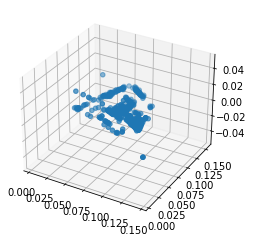

In [112]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

plt.interactive(True)
# Create a 3D scatter plot of the 3D world coordinates
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points_3d[:,0], points_3d[:,1], np.abs(points_3d[:,2]))
plt.show()

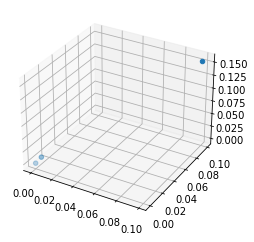

In [113]:
x = []
for i in range(len(points_3d)):
    
    if points_3d[i][2] == 0:
        x.append(points_3d[i])

plt.interactive(True)
# Create a 3D scatter plot of the 3D world coordinates
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[:][0], x[:][1], np.abs(x[:][2]))
plt.show()